In [21]:
import numpy as np
from imageio import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import sklearn.linear_model as skl
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, mean_absolute_error
from sklearn import linear_model
import random as rd
from sklearn.utils import resample

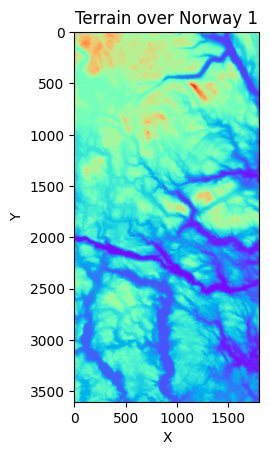

In [22]:
np.random.seed(1509)

# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')
# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap='rainbow')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

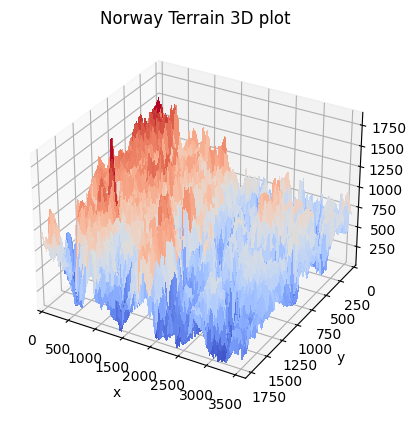

In [23]:
rows, cols = terrain1.shape

fig = plt.figure()
ax = fig.gca(projection='3d')

x, y = np.meshgrid(range(rows), range(cols))

# Plot the surface.
surf = ax.plot_surface(x.T, y.T, terrain1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.xlabel('x')
plt.ylabel('y')
ax.set_xlim(0,rows)
ax.set_ylim(cols, 0)

plt.title("Norway Terrain 3D plot")
plt.show()

(2000, 2)


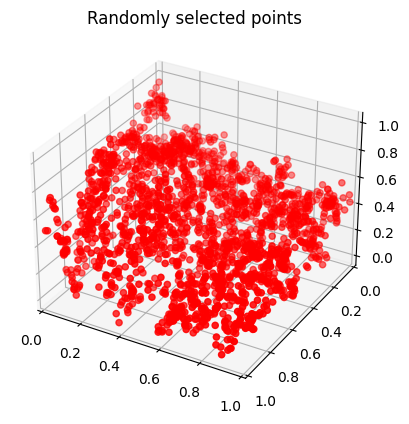

In [25]:
def min_max_scaler(data):
    """
    Perform Min-Max scaling on a given dataset.

    Min-Max scaling rescales the values in the input array 'X' to a given range
    .
    Parameters:
    x (np.array): The input dataset to be scaled.

    Returns:
    scaled(np.array): The scaled dataset with values in the range [0, 1].
    """
    min_i = min(data)
    max_i = max(data)
    
    scaled = (data-min_i)/(max_i-min_i)
    return scaled

def create_X(x, y, n ):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)

	N = len(x)
	l = int((n+1)*(n+2)/2)		# Number of elements in beta
	X = np.ones((N,l))

	for i in range(1,n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)

	return X

#Select n amount of data points to shorten running time
n = 2000

datapoints = np.zeros([n, 2])
z = np.zeros([n, 1])

datapoints = np.column_stack((np.random.randint(0, rows, size = n), np.random.randint(0, cols, size = n)))
print(datapoints.shape)
for i in range(n):
    z[i] = terrain1[int(datapoints[i, 0])][int(datapoints[i, 1])]

z = min_max_scaler(z)
datapoints = np.column_stack((min_max_scaler(datapoints[:,0]), min_max_scaler(datapoints[:,1])))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x, y = np.meshgrid(range(rows), range(cols))

scatter = ax.scatter(datapoints[:, 0], datapoints[:, 1], z, c='r', marker='o', label='Selected Points')
plt.title("Randomly selected points")
ax.set_xlim(0, 1)
ax.set_ylim(1, 0)
plt.show()


In [26]:
def c_tilde(deg, x):
    """
    Generate a subset of features from the input data matrix 'x' up to a specified degree 'deg',
    to use in predicting MSE and R2 score.

    Parameters:
    deg (int): The desired degree up to which features should be generated.
    x (np.array): The input data matrix containing one or more columns of features.

    Returns:
    c (int): The number of features generated up to degree 'i'.
    tilde (np.array): calculated tilde value of input
    """
    c = int((deg + 2) * (deg + 1) / 2)
    tilde = x[:,0:c-1]
    return c, tilde

PolynomialDegree = 20

#create design matrix X
X = create_X(datapoints[:, 0], datapoints[:, 1], PolynomialDegree)

#Remove intercept
X = X[:, 1:]

#Split into train and test sets
x_train, x_test, z_train, z_test = train_test_split(X, z, test_size = 0.2)

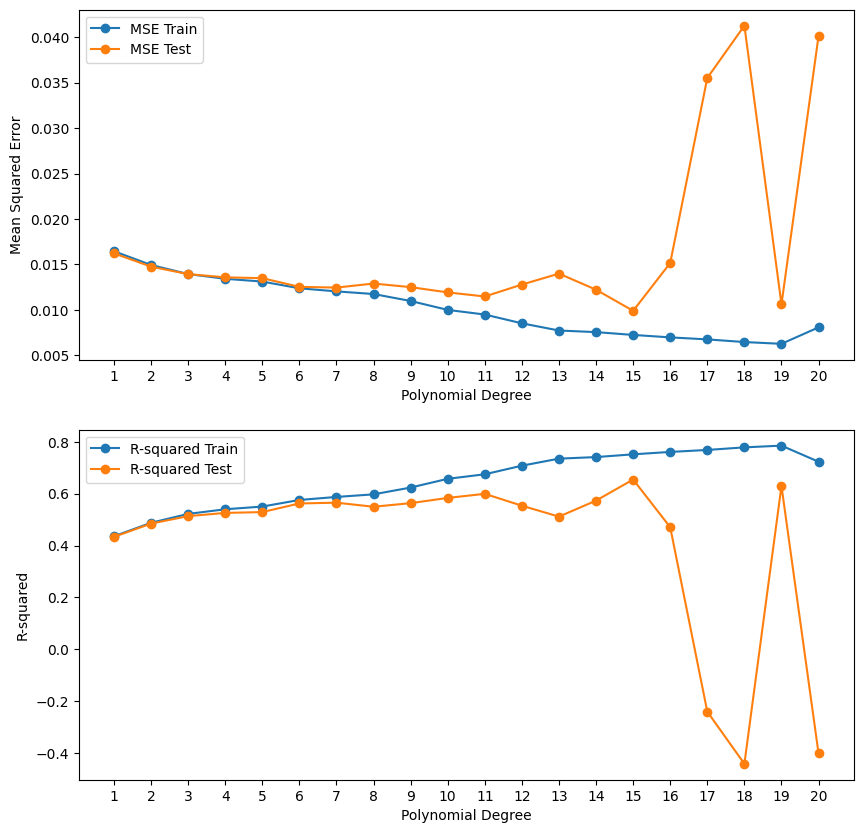

In [6]:
##OLS

MSETrain = np.zeros(PolynomialDegree)
MSETest = np.zeros(PolynomialDegree)
R2Train = np.zeros(PolynomialDegree)
R2Test = np.zeros(PolynomialDegree)

for degree in range(1, PolynomialDegree + 1):
    c, Xtilde = c_tilde(degree, x_train)

    model = LinearRegression(fit_intercept=True)
    model.fit(Xtilde, z_train)

    ztilde = model.predict(Xtilde)
    z_pred = model.predict(x_test[:, 0:c-1])

    MSETrain[degree-1] = mean_squared_error(z_train, ztilde)
    MSETest[degree-1] = mean_squared_error(z_test, z_pred)
    R2Train[degree-1] = r2_score(z_train, ztilde)
    R2Test[degree-1] = r2_score(z_test, z_pred)
degrees = np.arange(1, PolynomialDegree + 1)
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot MSE for train and test data
axes[0].plot(degrees, MSETrain, label='MSE Train', marker='o')
axes[0].plot(degrees, MSETest, label='MSE Test', marker='o')
axes[0].set_xlabel('Polynomial Degree')
axes[0].set_ylabel('Mean Squared Error')
axes[0].set_xticks(ticks = degrees)
axes[0].legend()

# Plot R2 for train and test data
axes[1].plot(degrees, R2Train, label='R-squared Train', marker='o')
axes[1].plot(degrees, R2Test, label='R-squared Test', marker='o')
axes[1].set_xlabel('Polynomial Degree')
axes[1].set_ylabel('R-squared')
axes[1].set_xticks(ticks = degrees)
axes[1].legend()


C:\Users\krise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.588e+00, tolerance: 4.668e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\krise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.928e+00, tolerance: 4.668e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\krise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-pac

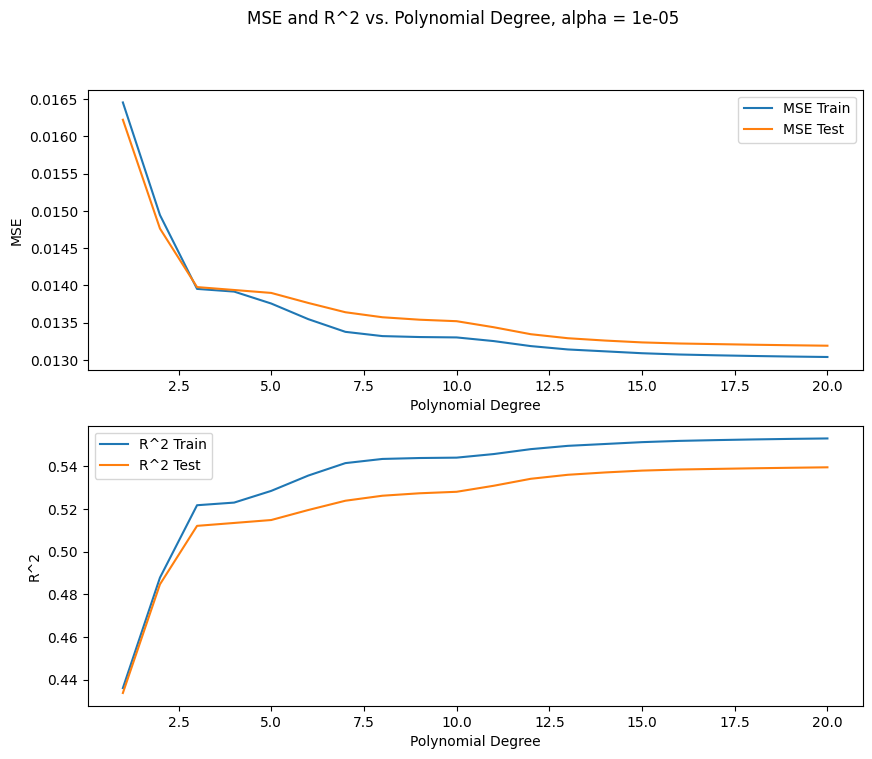

C:\Users\krise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.985e-02, tolerance: 4.668e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\krise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.445e-01, tolerance: 4.668e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\krise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-pac

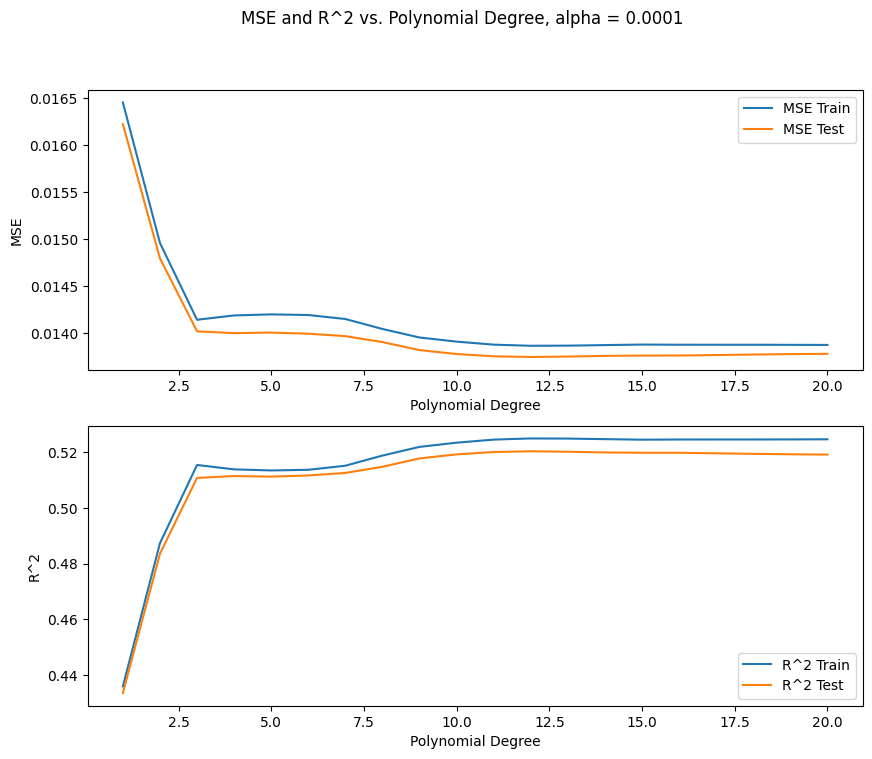

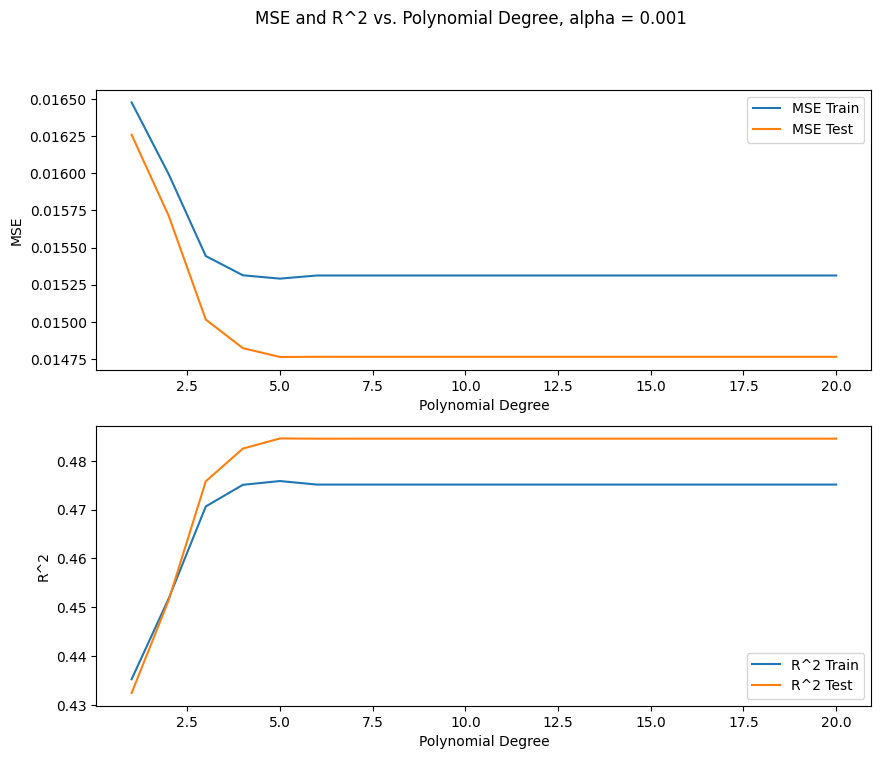

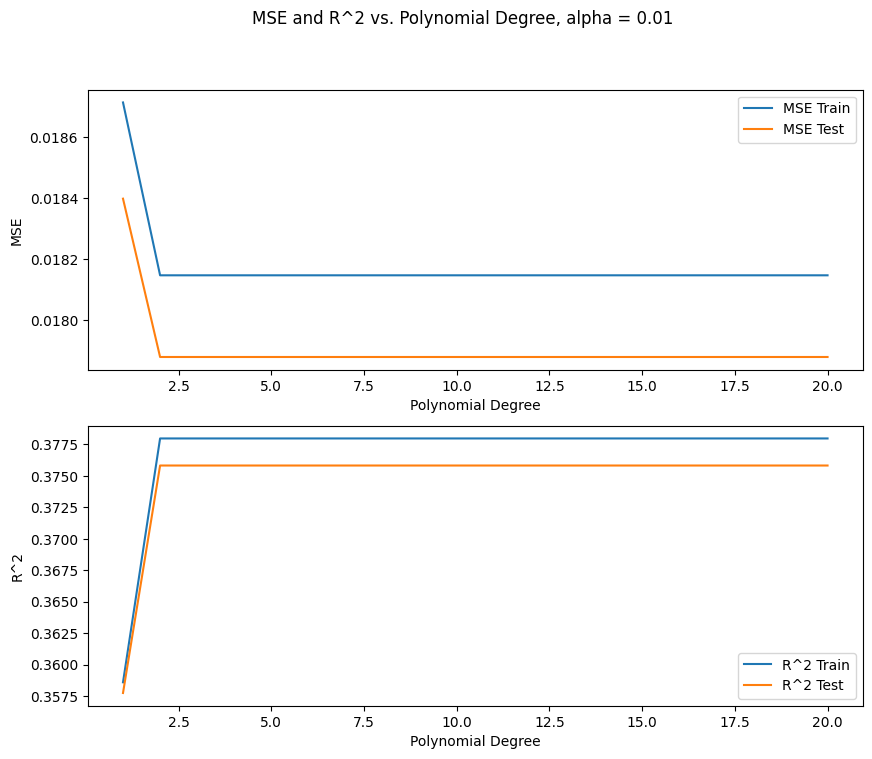

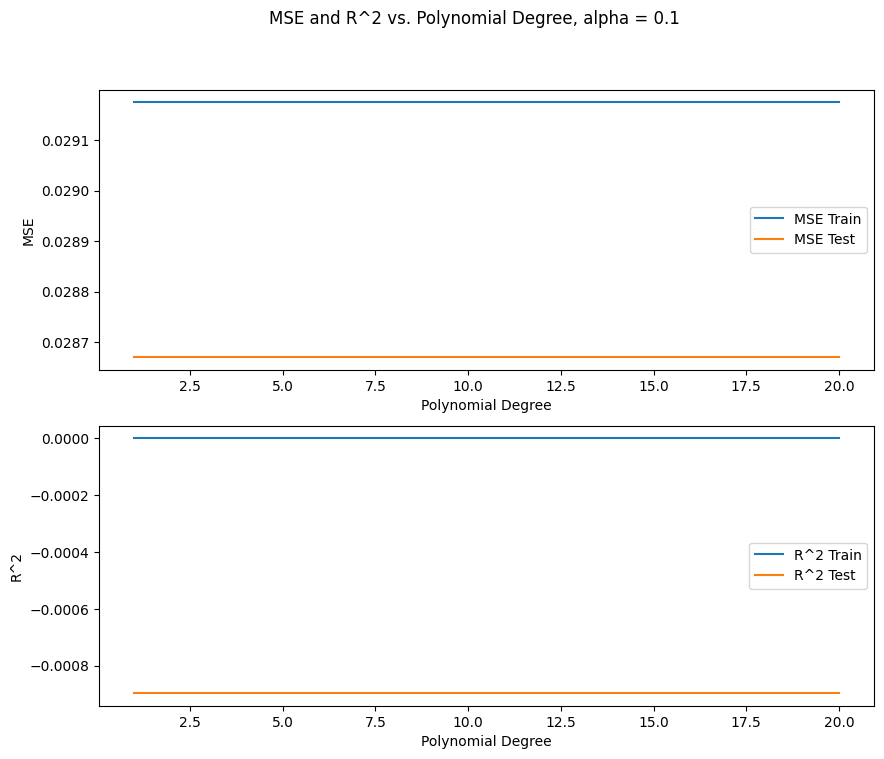

In [7]:
##Ridge
lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1]

MSETrain = np.zeros((PolynomialDegree))
MSETest = np.zeros((PolynomialDegree))
R2Train = np.zeros((PolynomialDegree))
R2Test = np.zeros((PolynomialDegree))


for lmbd in lambdas:
    MSETrain = np.zeros((PolynomialDegree))
    MSETest = np.zeros((PolynomialDegree))
    R2Train = np.zeros((PolynomialDegree))
    R2Test = np.zeros((PolynomialDegree))
    PolyDegree = np.zeros((PolynomialDegree))

    for degree in range(1, PolynomialDegree + 1):    
        c, Xtilde = c_tilde(degree, x_train)
        model = Lasso(lmbd)
        model.fit(Xtilde, z_train)

        ztilde = model.predict(Xtilde)
        z_pred = model.predict(x_test[:,0:c-1])

        MSETrain[degree -1] = mean_squared_error(z_train, ztilde)
        MSETest[degree-1] = mean_squared_error(z_test, z_pred)
        R2Train[degree-1] = r2_score(z_train, ztilde)
        R2Test[degree-1] = r2_score(z_test, z_pred)
        PolyDegree[degree-1] = degree

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    ax1.plot(PolyDegree, MSETrain, label='MSE Train')
    ax1.plot(PolyDegree, MSETest, label='MSE Test')
    ax1.set_xlabel('Polynomial Degree')
    ax1.set_ylabel('MSE')
    ax1.legend()
    ax2.plot(PolyDegree, R2Train, label='R^2 Train')
    ax2.plot(PolyDegree, R2Test, label='R^2 Test')
    ax2.set_xlabel('Polynomial Degree')
    ax2.set_ylabel('R^2')
    ax2.legend()
    plt.suptitle(f"MSE and R^2 vs. Polynomial Degree, alpha = {lmbd}")

    plt.show()

        




C:\Users\krise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.588e+00, tolerance: 4.668e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\krise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.928e+00, tolerance: 4.668e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\krise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-pac

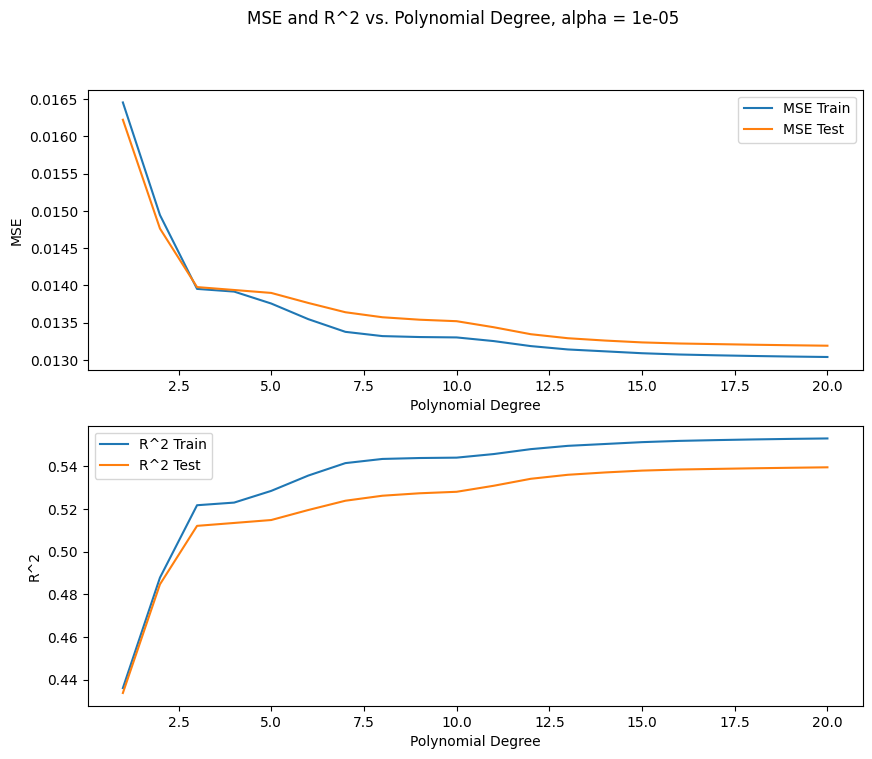

C:\Users\krise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.985e-02, tolerance: 4.668e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\krise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.445e-01, tolerance: 4.668e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\krise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-pac

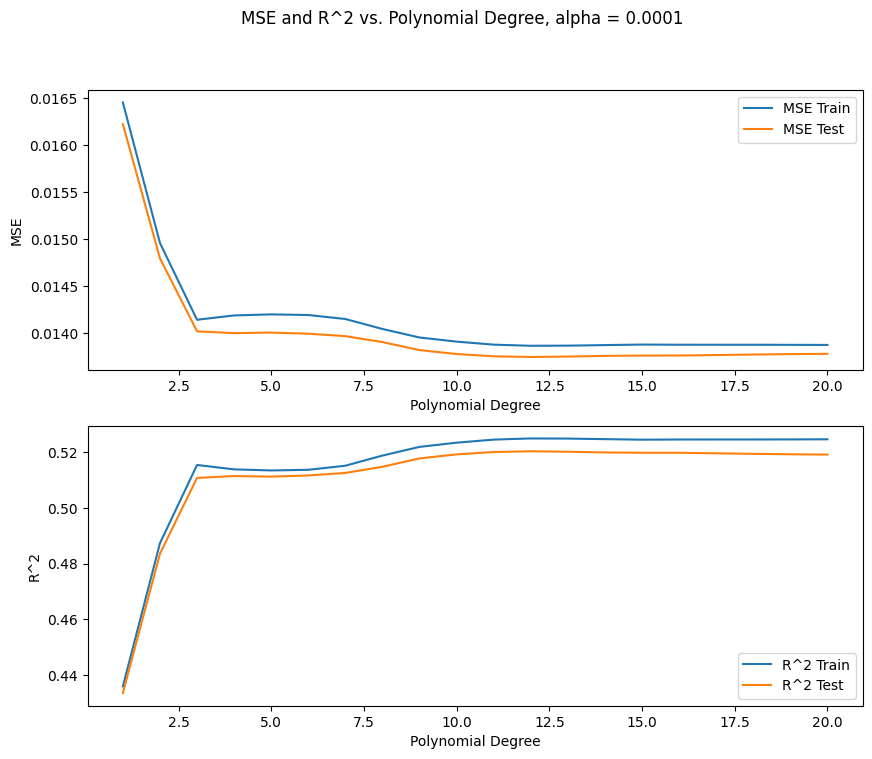

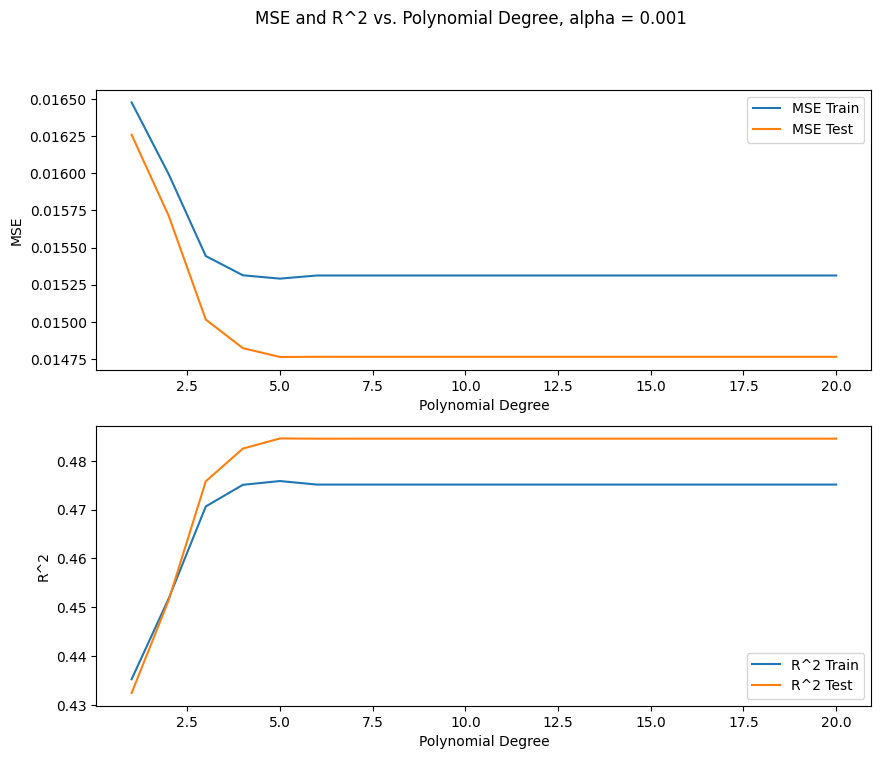

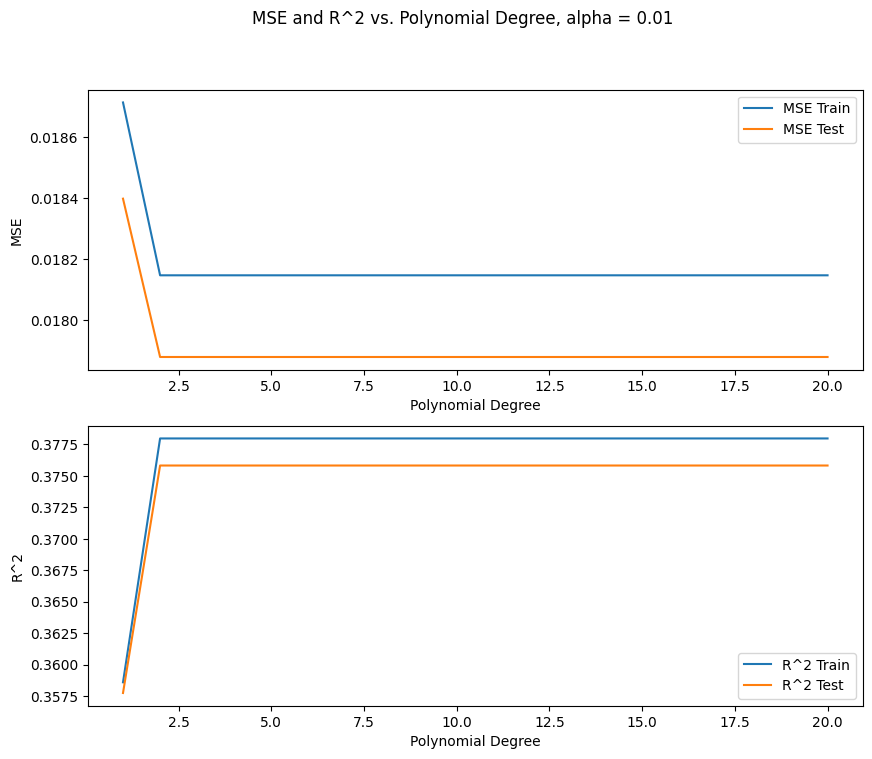

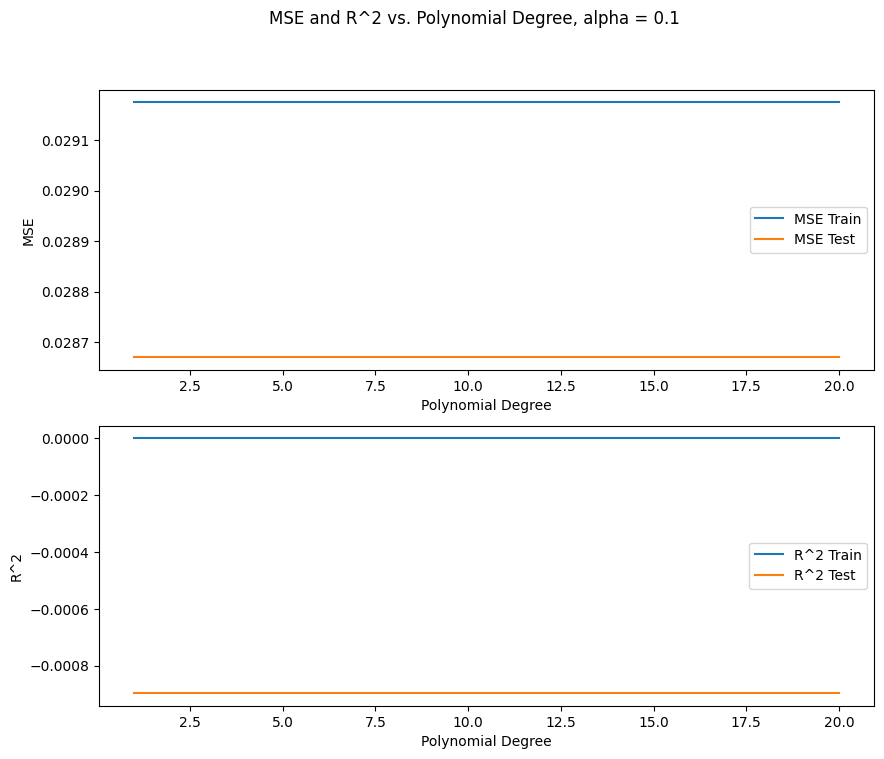

In [8]:
##Lasso
lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1]

MSETrain = np.zeros((PolynomialDegree))
MSETest = np.zeros((PolynomialDegree))
R2Train = np.zeros((PolynomialDegree))
R2Test = np.zeros((PolynomialDegree))


for lmbd in lambdas:
    MSETrain = np.zeros((PolynomialDegree))
    MSETest = np.zeros((PolynomialDegree))
    R2Train = np.zeros((PolynomialDegree))
    R2Test = np.zeros((PolynomialDegree))
    PolyDegree = np.zeros((PolynomialDegree))

    for degree in range(1, PolynomialDegree + 1):    
        c, Xtilde = c_tilde(degree, x_train)
        model = Lasso(lmbd)
        model.fit(Xtilde, z_train)

        ztilde = model.predict(Xtilde)
        z_pred = model.predict(x_test[:,0:c-1])

        MSETrain[degree -1] = mean_squared_error(z_train, ztilde)
        MSETest[degree-1] = mean_squared_error(z_test, z_pred)
        R2Train[degree-1] = r2_score(z_train, ztilde)
        R2Test[degree-1] = r2_score(z_test, z_pred)
        PolyDegree[degree-1] = degree

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    ax1.plot(PolyDegree, MSETrain, label='MSE Train')
    ax1.plot(PolyDegree, MSETest, label='MSE Test')
    ax1.set_xlabel('Polynomial Degree')
    ax1.set_ylabel('MSE')
    ax1.legend()
    ax2.plot(PolyDegree, R2Train, label='R^2 Train')
    ax2.plot(PolyDegree, R2Test, label='R^2 Test')
    ax2.set_xlabel('Polynomial Degree')
    ax2.set_ylabel('R^2')
    ax2.legend()
    plt.suptitle(f"MSE and R^2 vs. Polynomial Degree, alpha = {lmbd}")

    plt.show()

        


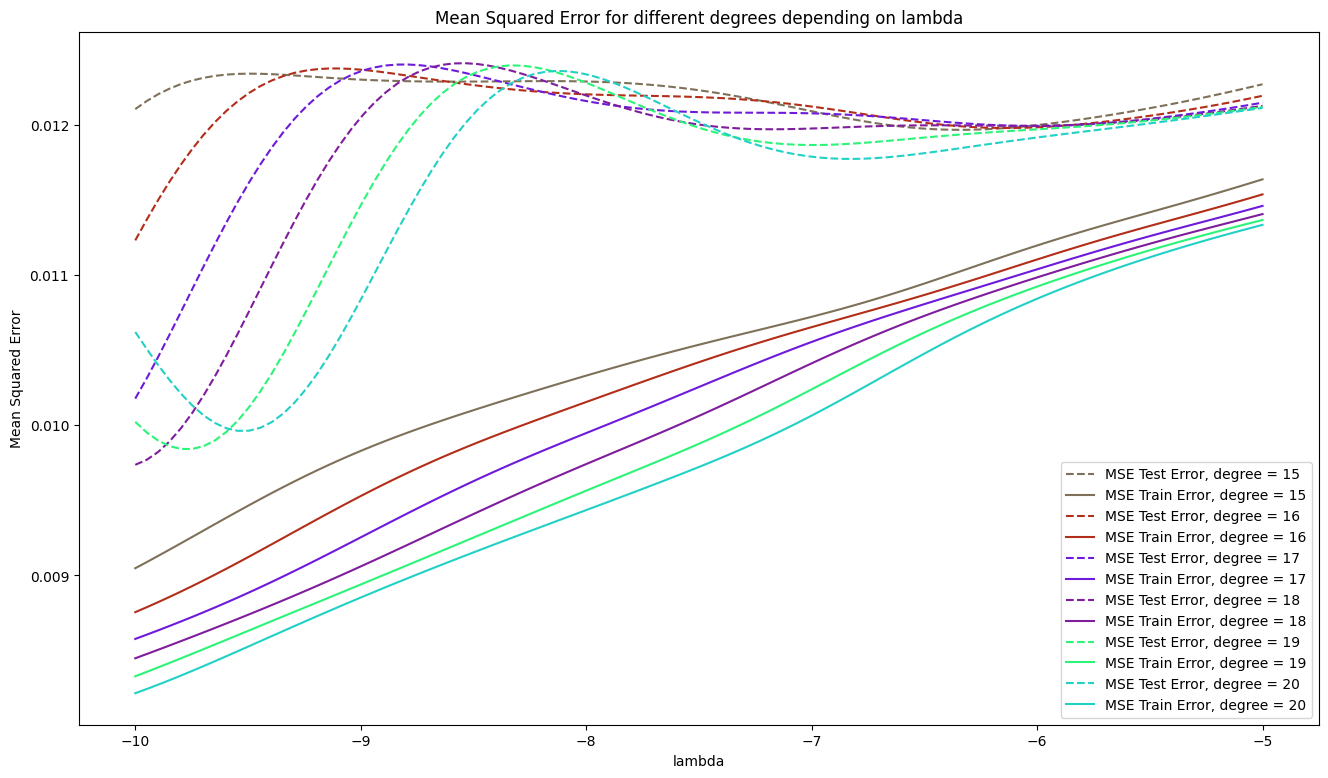

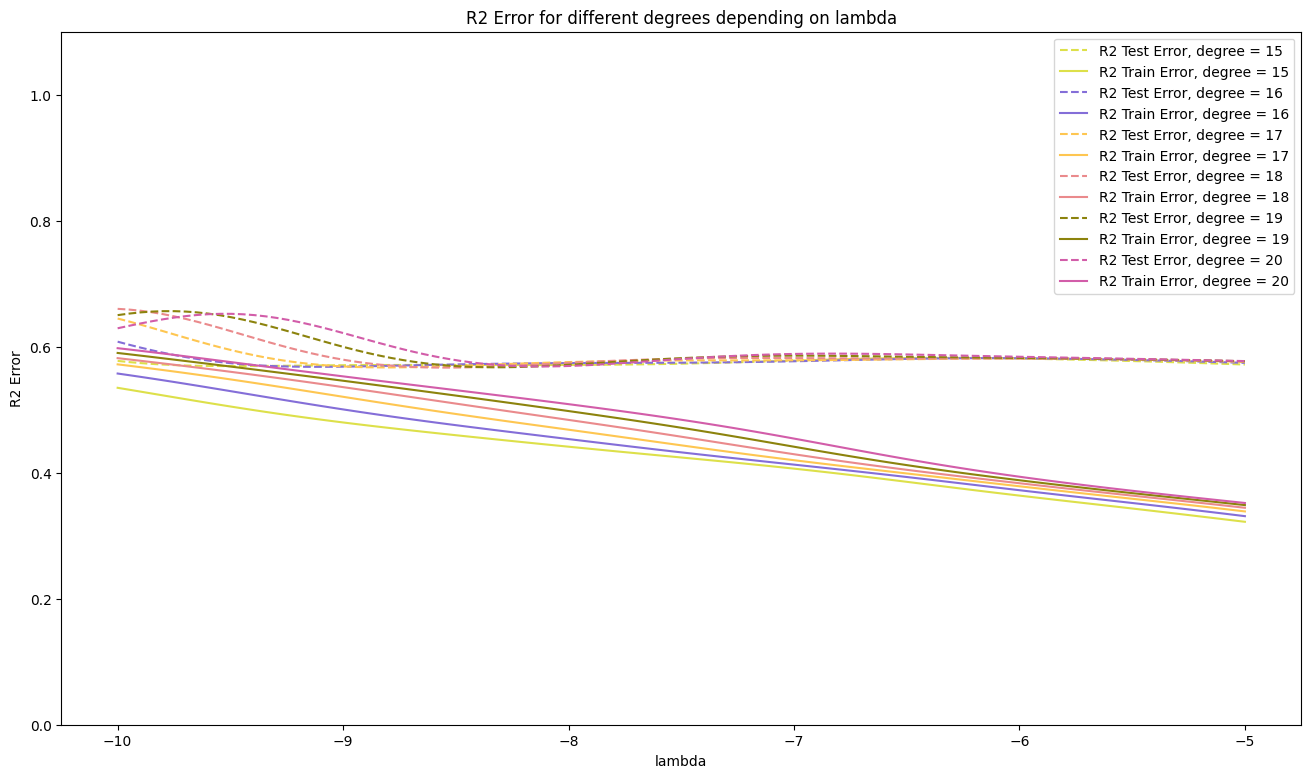

In [9]:
lambdas = np.logspace(-10,-5, 100)
DegreeStart = 15

MSETrainAllLambdas = []
MSETestAllLambdas = []
R2TrainAllLambdas = []
R2TestAllLambdas = []

# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

for degree in range(DegreeStart, PolynomialDegree+1):
    PolyDegree = []

    MSETrain = []
    MSETest = []

    R2Train = []
    R2Test = []
    
    for lamb in lambdas:
        c, Xtilde = c_tilde(degree, x_train)
        model = linear_model.Ridge(lamb)
        model.fit(Xtilde, z_train)

        ztilde = model.predict(Xtilde)
        z_pred = model.predict(x_test[:,0:c-1])

        MSETrain.append(mean_squared_error(ztilde,z_train))
        MSETest.append(mean_squared_error(z_test, z_pred))
        R2Train.append(r2_score(ztilde, z_train))
        R2Test.append(r2_score(z_test, z_pred))
        PolyDegree.append(degree)

    MSETrainAllLambdas.append(MSETrain)
    MSETestAllLambdas.append(MSETest)
    R2TrainAllLambdas.append(R2Train)
    R2TestAllLambdas.append(R2Test)

plt.figure(figsize=(16,9))
for i in range(0, len(MSETrainAllLambdas)):
    color = "%06x" % rd.randint(0, 0xFFFFFF) # Keep both Train and Test the same color
    plt.plot(np.log10(lambdas), MSETestAllLambdas[i], linestyle = '--', color = "#" + color, label=f'MSE Test Error, degree = {i+DegreeStart}')
    plt.plot(np.log10(lambdas), MSETrainAllLambdas[i], color = "#" + color, label=f'MSE Train Error, degree = {i+DegreeStart}')
plt.xlabel("lambda")
plt.ylabel("Mean Squared Error")
plt.title(f"Mean Squared Error for different degrees depending on lambda")
plt.legend()
plt.show()

plt.figure(figsize=(16,9))
for i in range(0, len(R2TrainAllLambdas)):
    color = "%06x" % rd.randint(0, 0xFFFFFF) # Keep both Train and Test the same color
    plt.plot(np.log10(lambdas), R2TestAllLambdas[i], linestyle = '--', color = "#" + color, label=f'R2 Test Error, degree = {i+DegreeStart}')
    plt.plot(np.log10(lambdas), R2TrainAllLambdas[i], color = "#" + color, label=f'R2 Train Error, degree = {i+DegreeStart}')
plt.xlabel("lambda")
plt.ylabel("R2 Error")
plt.ylim(0,1.1)
plt.title(f"R2 Error for different degrees depending on lambda")
plt.legend()
plt.show()

C:\Users\krise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.029e+01, tolerance: 4.668e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\krise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.029e+01, tolerance: 4.668e-03
  model = cd_fast.enet_coordinate_descent(
C:\Users\krise\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-pac

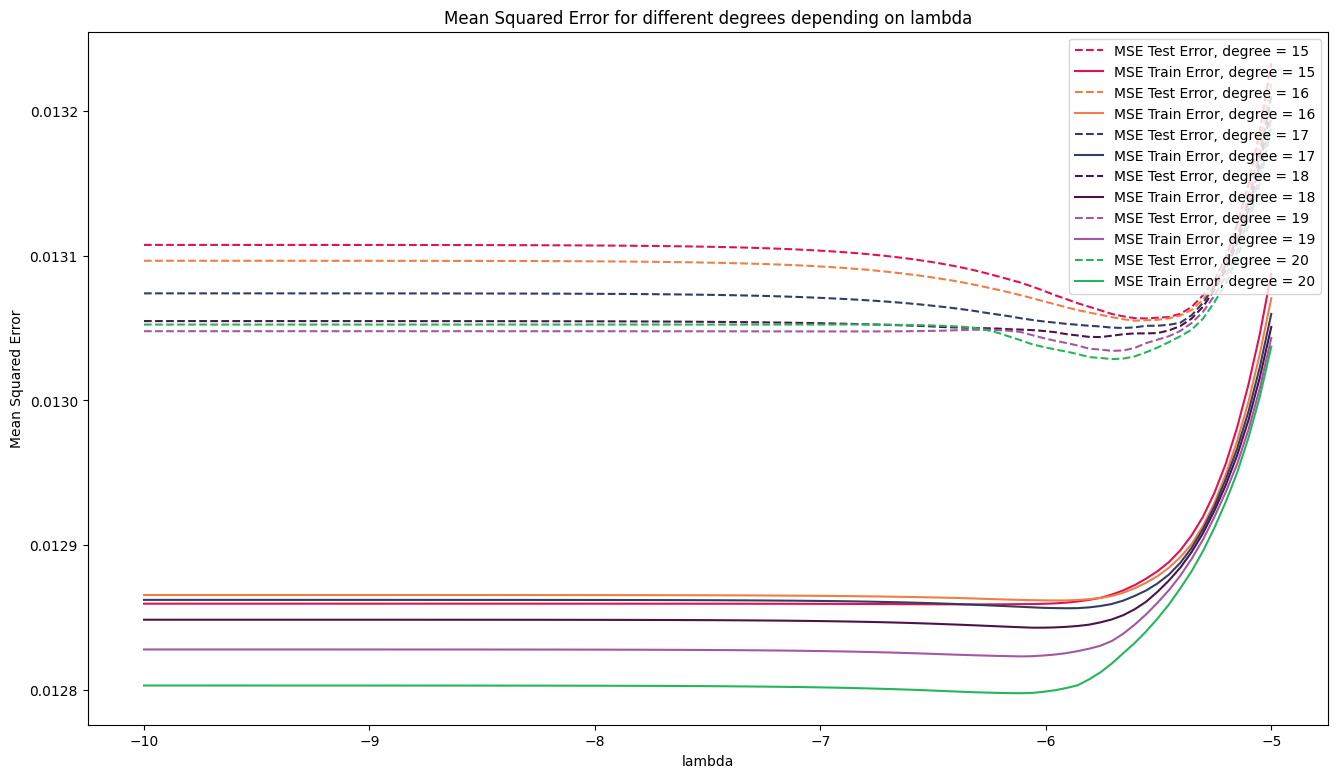

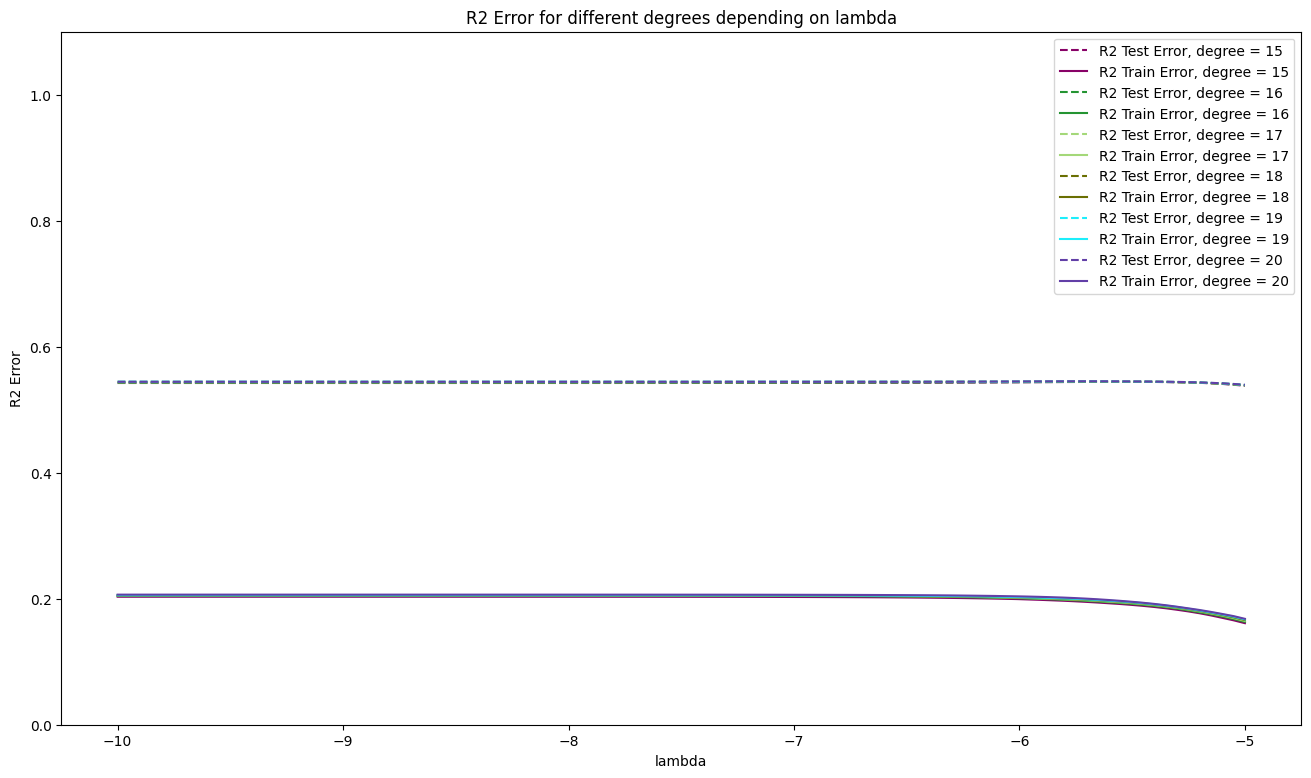

In [10]:
lambdas = np.logspace(-10,-5, 100)
DegreeStart = 15

MSETrainAllLambdas = []
MSETestAllLambdas = []
R2TrainAllLambdas = []
R2TestAllLambdas = []

# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

for degree in range(DegreeStart, PolynomialDegree+1):
    PolyDegree = []

    MSETrain = []
    MSETest = []

    R2Train = []
    R2Test = []
    
    for lamb in lambdas:
        c, Xtilde = c_tilde(degree, x_train)
        model = Lasso(lamb)
        model.fit(Xtilde, z_train)

        ztilde = model.predict(Xtilde)
        z_pred = model.predict(x_test[:,0:c-1])

        MSETrain.append(mean_squared_error(ztilde,z_train))
        MSETest.append(mean_squared_error(z_test, z_pred))
        R2Train.append(r2_score(ztilde, z_train))
        R2Test.append(r2_score(z_test, z_pred))
        PolyDegree.append(degree)

    MSETrainAllLambdas.append(MSETrain)
    MSETestAllLambdas.append(MSETest)
    R2TrainAllLambdas.append(R2Train)
    R2TestAllLambdas.append(R2Test)

plt.figure(figsize=(16,9))
for i in range(0, len(MSETrainAllLambdas)):
    color = "%06x" % rd.randint(0, 0xFFFFFF) # Keep both Train and Test the same color
    plt.plot(np.log10(lambdas), MSETestAllLambdas[i], linestyle = '--', color = "#" + color, label=f'MSE Test Error, degree = {i+DegreeStart}')
    plt.plot(np.log10(lambdas), MSETrainAllLambdas[i], color = "#" + color, label=f'MSE Train Error, degree = {i+DegreeStart}')
plt.xlabel("lambda")
plt.ylabel("Mean Squared Error")
plt.title(f"Mean Squared Error for different degrees depending on lambda")
plt.legend()
plt.show()

plt.figure(figsize=(16,9))
for i in range(0, len(R2TrainAllLambdas)):
    color = "%06x" % rd.randint(0, 0xFFFFFF) # Keep both Train and Test the same color
    plt.plot(np.log10(lambdas), R2TestAllLambdas[i], linestyle = '--', color = "#" + color, label=f'R2 Test Error, degree = {i+DegreeStart}')
    plt.plot(np.log10(lambdas), R2TrainAllLambdas[i], color = "#" + color, label=f'R2 Train Error, degree = {i+DegreeStart}')
plt.xlabel("lambda")
plt.ylabel("R2 Error")
plt.ylim(0,1.1)
plt.title(f"R2 Error for different degrees depending on lambda")
plt.legend()
plt.show()

Degree of polynomial:   1
Mean squared error on training data: 0.15358195
Mean squared error on test data: 0.15273972
Degree of polynomial:   2
Mean squared error on training data: 0.12753797
Mean squared error on test data: 0.12732369
Degree of polynomial:   3
Mean squared error on training data: 0.12447452
Mean squared error on test data: 0.12435578
Degree of polynomial:   4
Mean squared error on training data: 0.12430754
Mean squared error on test data: 0.12430754
Degree of polynomial:   5
Mean squared error on training data: 0.12438800
Mean squared error on test data: 0.12438800
Degree of polynomial:   6
Mean squared error on training data: 0.12429039
Mean squared error on test data: 0.12429039
Degree of polynomial:   7
Mean squared error on training data: 0.12412696
Mean squared error on test data: 0.12412696
Degree of polynomial:   8
Mean squared error on training data: 0.12442229
Mean squared error on test data: 0.12442229
Degree of polynomial:   9
Mean squared error on training

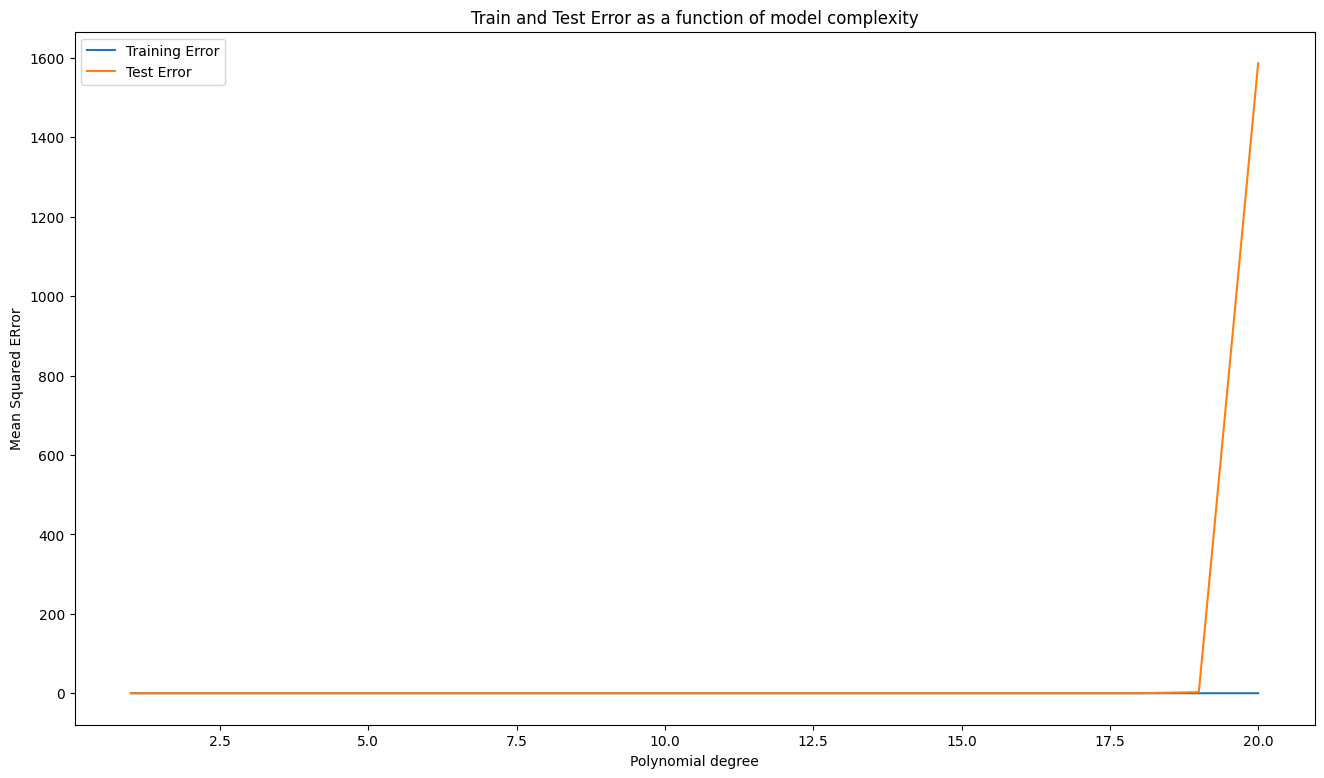

In [11]:

X = np.zeros((len(datapoints),PolynomialDegree))
X[:,0] = 1.0
testerror = np.zeros(PolynomialDegree)
trainingerror = np.zeros(PolynomialDegree)
polynomial = np.zeros(PolynomialDegree)

trials = 100
for polydegree in range(1, PolynomialDegree + 1):
    polynomial[polydegree - 1] = polydegree
    for degree in range(polydegree):
        X[:,degree] = z[:,0]**(degree/3.0)

# loop over trials in order to estimate the expectation value of the MSE
    testerror[polydegree - 1] = 0.0
    trainingerror[polydegree - 1] = 0.0
    for samples in range(trials):
        X_train, X_test, z_train, z_tests = train_test_split(X, z, test_size=0.2)
        scaler = StandardScaler()
        scaler.fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        model = LinearRegression(fit_intercept=False).fit(X_train_scaled, z_train)
        zpred = model.predict(X_train_scaled)
        ztilde = model.predict(X_test_scaled)
        testerror[polydegree - 1] += mean_squared_error(z_tests, ztilde)
        trainingerror[polydegree - 1] += mean_squared_error(z_train, zpred) 

    testerror[polydegree - 1] /= trials
    trainingerror[polydegree - 1] /= trials
    print("Degree of polynomial: %3d"% polynomial[polydegree - 1])
    print("Mean squared error on training data: %.8f" % trainingerror[polydegree - 1])
    print("Mean squared error on test data: %.8f" % testerror[polydegree - 1])

plt.figure(figsize=(16,9))
plt.plot(polynomial, trainingerror, label='Training Error')
plt.plot(polynomial, testerror, label='Test Error')
plt.xlabel('Polynomial degree')
plt.ylabel('Mean Squared ERror')
plt.title("Train and Test Error as a function of model complexity")
plt.legend()
plt.show()

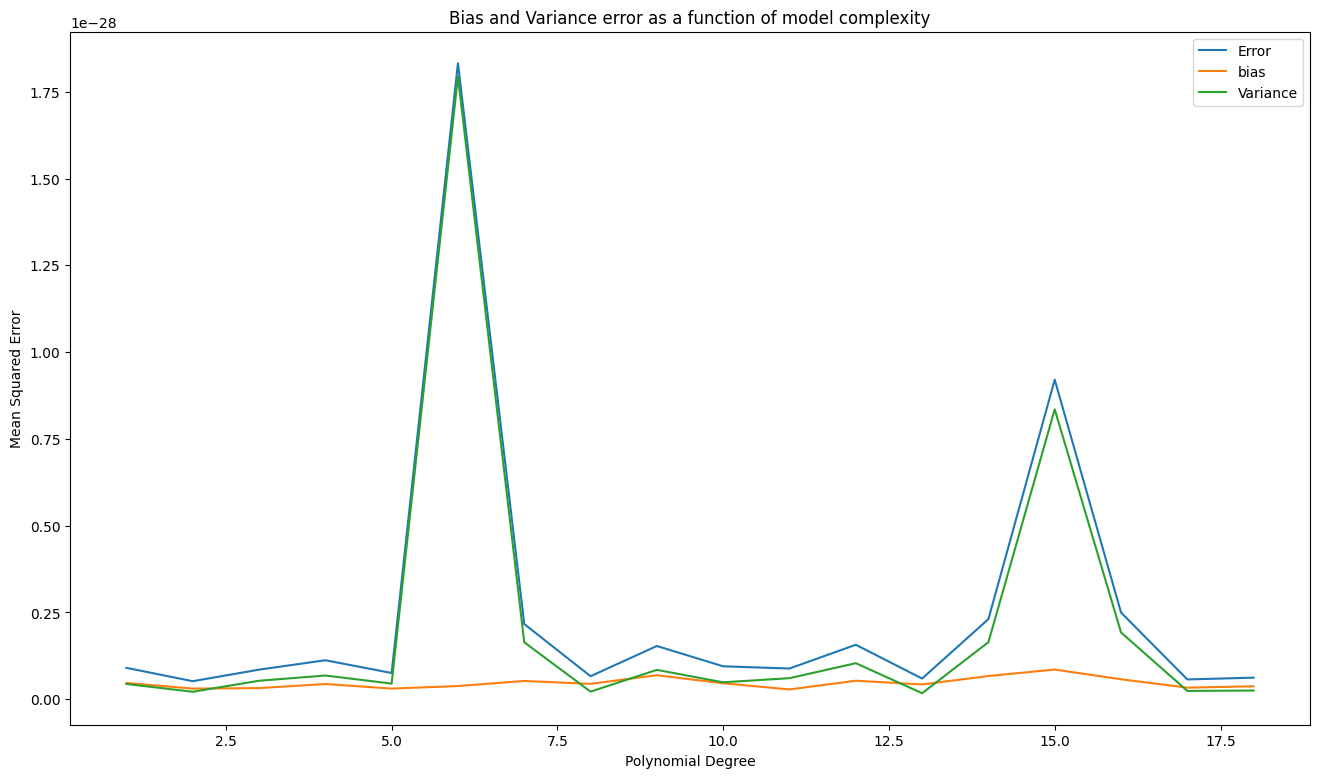

In [12]:
np.random.seed(4242)

n_boostraps = 100
maxdegree = 18
error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)

for degree in range(1, maxdegree + 1):
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)
    z_test = z_test.reshape(-1,1)

    # scaler = StandardScaler()
    # scaler.fit(X_train)
    # X_train_scaled = scaler.transform(X_train)
    # X_test_scaled = scaler.transform(X_test)

    model = make_pipeline(LinearRegression(fit_intercept=False))
    z_pred = np.empty((z_test.shape[0], n_boostraps))
    for i in range(n_boostraps):
        x_, y_ = resample(X_train, z_train)
        z_pred[:, i] = model.fit(x_, y_).predict(X_test).ravel()
    polydegree[degree - 1] = degree
    error[degree - 1] = np.mean( np.mean((z_test - z_pred)**2, axis=1, keepdims=True) )
    bias[degree - 1] = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance[degree - 1] = np.mean( np.var(z_pred, axis=1, keepdims=True) )

plt.figure(figsize=(16,9))
plt.plot(polydegree, error, label='Error')
plt.plot(polydegree, bias, label='bias')
plt.plot(polydegree, variance, label='Variance')
plt.xlabel("Polynomial Degree")
plt.ylabel("Mean Squared Error")
plt.title("Bias and Variance error as a function of model complexity")
plt.legend()
plt.show()

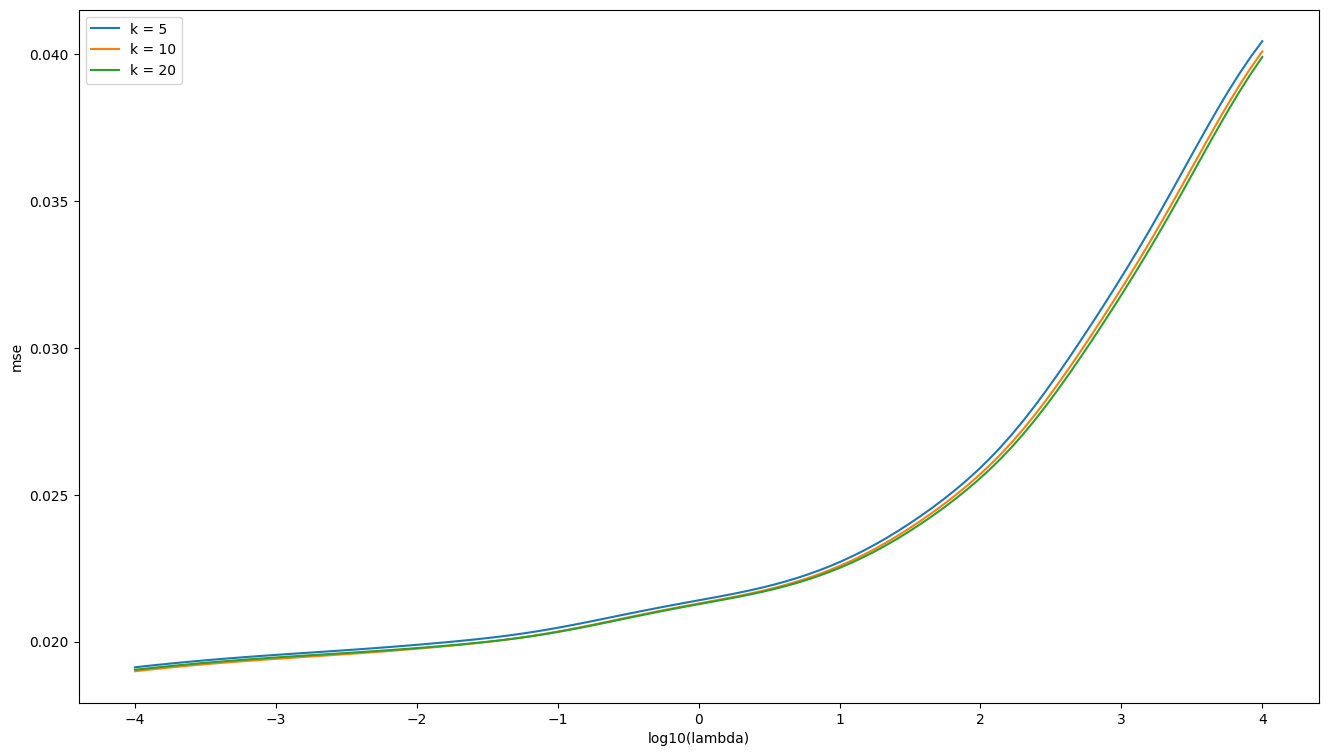

In [28]:
"""
# A seed just to ensure that the random numbers are the same for every run.
# Useful for eventual debugging.
np.random.seed(3155)

## Cross-validation on Ridge regression using KFold only

# Decide degree on polynomial to fit
poly = PolynomialFeatures(degree = degree)

# Decide which values of lambda to use
nlambdas = 50
lambdas = np.logspace(-4, 4, nlambdas)

# Initialize a KFold instance
k = 10
kfold = KFold(n_splits = k)

# Perform the cross-validation to estimate MSE
scores_KFold = np.zeros((nlambdas, k))

i = 0
for lmb in lambdas:
    ridge = Ridge(alpha = lmb)
    j = 0
    for train_inds, test_inds in kfold.split(x):
        xtrain = x[train_inds]
        ytrain = y[train_inds]

        xtest = x[test_inds]
        ytest = y[test_inds]

        print(xtrain.shape)

        Xtrain = poly.fit_transform(xtrain[:, 0])
        ridge.fit(Xtrain, ytrain[:, np.newaxis])

        Xtest = poly.fit_transform(xtest[:, np.newaxis])
        ypred = ridge.predict(Xtest)

        scores_KFold[i,j] = np.sum((ypred - ytest[:, np.newaxis])**2)/np.size(ypred)

        j += 1
    i += 1


estimated_mse_KFold = np.mean(scores_KFold, axis = 1)

## Cross-validation using cross_val_score from sklearn along with KFold

# kfold is an instance initialized above as:
# kfold = KFold(n_splits = k)

estimated_mse_sklearn = np.zeros(nlambdas)
i = 0
for lmb in lambdas:
    ridge = Ridge(alpha = lmb)

    x = poly.fit_transform(x[:, np.newaxis])
    estimated_mse_folds = cross_val_score(ridge, x, z[:, np.newaxis], scoring='neg_mean_squared_error', cv=kfold)

    # cross_val_score return an array containing the estimated negative mse for every fold.
    # we have to the the mean of every array in order to get an estimate of the mse of the model
    estimated_mse_sklearn[i] = np.mean(-estimated_mse_folds)

    i += 1

## Plot and compare the slightly different ways to perform cross-validation

plt.figure(figsize=(16,9))
plt.plot(np.log10(lambdas), estimated_mse_sklearn, label = 'cross_val_score')
plt.plot(np.log10(lambdas), estimated_mse_KFold, 'r--', label = 'KFold')

plt.xlabel('log10(lambda)')
plt.ylabel('mse')

plt.legend()

plt.show()
"""

mseRidge_5 = np.zeros(nlambdas)
mseRidge_10 = np.zeros(nlambdas)
mseRidge_20 = np.zeros(nlambdas)

k_dict = {
        5: mseRidge_5,
        10: mseRidge_10,
        20: mseRidge_20

    }
nlambdas = 100
lambdas = np.logspace(-4, 4, nlambdas)

z_train = z_train.ravel()

for k, k_array in k_dict.items():
    kfold = KFold(n_splits = k)
    i = 0
    for lmbd in lambdas:
        model = linear_model.Ridge(alpha = lmbd)
        mse_folds = cross_val_score(model, x_train, z_train[:, np.newaxis], scoring='neg_mean_squared_error', cv=kfold)
        k_array[i] = np.mean(-mse_folds)

        i += 1


plt.figure(figsize=(16,9))
plt.plot(np.log10(lambdas), mseRidge_5, label = 'k = 5')
plt.plot(np.log10(lambdas), mseRidge_10, label = 'k = 10')
plt.plot(np.log10(lambdas), mseRidge_20, label = 'k = 20')

plt.xlabel('log10(lambda)')
plt.ylabel('mse')

plt.legend()

plt.show()


